In [1]:
# general
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
pd.options.display.float_format = '{:,.4f}'.format

# 0. Read Training Data

In [4]:
import xgboost  
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold

In [5]:
validation_data = pd.read_csv('validation_data.csv')

In [6]:
validation_data[validation_data['title_name'] == 'Wonder Woman 1984']

,Unnamed: 0,title_name,title_id,season_number,days_on_hbo_max,cumulative_hours_viewed,average_hours_viewed,offering_start_date,asset_run_time_hours,content_category,program_type,air_date,medal,episode_number_in_season,pillar_genre,is_pay_1,is_popcorn,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Adult Animation,genre_Classics,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Kids/Family,genre_Music,genre_Other,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,genre_Unscripted,medal_number,is_new_content,age_of_content,content_category_livesports.1,content_category_movies.1,content_category_series.1,content_category_special.1,program_type_acquired.1,program_type_original.1,genre_Action/Adventure .1,genre_Adult Animation.1,genre_Classics.1,genre_Comedy.1,genre_Documentary.1,genre_Drama.1,genre_Horror .1,genre_Kids/Family.1,genre_Music.1,genre_Other.1,genre_Romance.1,genre_Sci-Fi.1,genre_Suspense/Thriller.1,genre_Unscripted.1,content_category_livesports.2,content_category_movies.2,content_category_series.2,content_category_special.2,program_type_acquired.2,program_type_original.2,genre_Action/Adventure .2,genre_Adult Animation.2,genre_Classics.2,genre_Comedy.2,genre_Documentary.2,genre_Drama.2,genre_Horror .2,genre_Kids/Family.2,genre_Music.2,genre_Other.2,genre_Romance.2,genre_Sci-Fi.2,genre_Suspense/Thriller.2,genre_Unscripted.2,hvr,ahvr,content_cost
1680,1680,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,60,"29,858,928.5688",3.7052,2020-12-25,2.4669,movies,acquired,2020-01-01,Platinum,nan,Action/Adventure,1,1,"200,000,000.0000",0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,1,0.9829,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"12,103,610.2031",1.5019,"39,454,083.0000"


# 1. Modeling - Cross Validation

In [7]:
META_COLS = ['title_name', 'title_id', 'season_number', 'offering_start_date', 'air_date','asset_run_time_hours',
            'content_category', 'program_type', 'medal', 'pillar_genre']

In [8]:
FEATURE_COLS = ['is_pay_1', 
                'is_popcorn', 
#                 'is_new_content', 
                'medal_number', 
                'age_of_content', 
                'content_cost', #XX
#                 'budget', 
#                 'content_category_livesports', 
                'content_category_movies', 
                'content_category_series', 
#                 'content_category_special', 
                'program_type_acquired', 
                'program_type_original', 
                'genre_Action/Adventure ', 
#                 'Dominant_Topic_7.0'    XX
                'genre_Classics',  
                'genre_Horror '
               ]

In [9]:
TARGET_COL = ['ahvr'] # cumulative_first_views

In [10]:
def cal_error(validation_set):
    error_col = ((validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]).abs()
    return error_col.mean()

## 1.1 Random Forest CV

In [11]:
# training_data = validation_data[validation_data['ahvr']>0.03]
# training_data = training_data[META_COLS+FEATURE_COLS+TARGET_COL]

In [12]:
# training_data = training_data.sort_values(by = ['offering_start_date']).reset_index(drop = True)

In [13]:
num_fold = 10
group_kfold = GroupKFold(n_splits=num_fold)

In [14]:
len(validation_data)

7407

In [15]:
training_data['group_num'] = training_data.index

NameError: name 'training_data' is not defined

In [ ]:
training_data['group_num'] = (training_data['group_num']/ (len(training_data)/num_fold)).apply(np.floor)

In [16]:
training_data.tail()

NameError: name 'training_data' is not defined

In [72]:
validation_set = pd.DataFrame()
feature_importances = pd.DataFrame()
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
    
    offer_date = test_df['offering_start_date'].min()
#     train_df = train_df[train_df['offering_start_date']<=offer_date]
#     if offer_date == '2020-05-27':
#         print ('pass')
#         continue
    n_record = len(train_df.title_id.unique())
    print ("n of Validation Title: " + str(n_record))
    n_record = len(test_df.title_id.unique())
    print ("n of Test Title: " + str(n_record))
#     print (test_df.offering_start_date.unique())
    try:
        ## fit_predict prelaunch model
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]
        
        

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

#         fi = model.feature_importances_
#         fi_df = pd.DataFrame([fi])
#         fi_df.columns = FEATURE_COLS
#         fi_df['match_id'] = test_df['match_id'].values[0]
#         fi_df['title_name'] = test_df['title_name'].values[0]
#         fi_df['days_on_hbo_max'] = day
#         feature_importances=pd.concat([feature_importances, fi_df], axis = 0)

#     except (KeyboardInterrupt, SystemExit):
#         raise

    except:
#         print (test_df[''])
        print ('Failed')
        # raise

n of Validation Title: 372
n of Test Title: 26
n of Validation Title: 360
n of Test Title: 38
n of Validation Title: 358
n of Test Title: 40
n of Validation Title: 357
n of Test Title: 41
n of Validation Title: 356
n of Test Title: 42
n of Validation Title: 356
n of Test Title: 42
n of Validation Title: 355
n of Test Title: 43
n of Validation Title: 356
n of Test Title: 42
n of Validation Title: 356
n of Test Title: 42
n of Validation Title: 356
n of Test Title: 42


In [73]:
cal_error(validation_set)

0.9938645769594675

In [74]:
validation_set['pct_error'] = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]

In [75]:
validation_set[validation_set['title_name']=='Wonder Woman 1984']

,title_name,title_id,season_number,offering_start_date,asset_run_time_hours,is_pay_1,is_popcorn,medal_number,age_of_content,content_cost,content_category_movies,content_category_series,genre_Action/Adventure,ahvr,log_ahvr,group_num,pred,pct_error
29,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,2020-12-25,2.4669,1,1,0.0000,0.9829,"39,454,083.0000",1,0,1,1.5019,0.5868,6.0000,0.2100,0.8602


In [141]:
validation_set[validation_set['pct_error']>2]

,title_name,title_id,season_number,offering_start_date,asset_run_time_hours,is_pay_1,is_popcorn,is_new_content,medal_number,age_of_content,content_cost,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,program_type_acquired,program_type_original,genre_Action/Adventure,Dominant_Topic_7.0,ahvr,group_num,pred,pct_error
1,South Park,GXr7SEgRi2sLCAAEAAAQu,1,2020-06-24,4.7847,0,0,0,nan,22.4782,"416,645,951.0000","300,000.0000",0,0,1,0,1,0,0,0,0.0537,3.0000,0.2013,2.7487
2,South Park,GXr7SEgRi2sLCAAEAAAQu,4,2020-06-24,6.2522,0,0,0,nan,20.4795,nan,nan,0,0,1,0,1,0,0,0,0.0516,3.0000,0.2036,2.9430
11,South Park,GXr7SEgRi2sLCAAEAAAQu,15,2020-06-24,5.1492,0,0,0,nan,9.4786,nan,nan,0,0,1,0,1,0,0,0,0.0651,3.0000,0.1952,2.0004
21,It,GWt7vKAJzFri8vQEAAAKm,0,2020-10-27,2.1964,0,0,0,nan,3.8194,"9,029,193.0000","35,000,000.0000",0,1,0,0,1,0,0,1,0.0585,5.0000,0.1884,2.2182
26,Reminiscence,GYQBEaQwta8PCAAEAAAA-,0,2021-08-20,1.8928,1,1,1,0.0000,0.0000,"12,050,725.0000","54,000,000.0000",0,1,0,0,1,0,0,0,0.0519,7.0000,0.1697,2.2692
17,A West Wing Special to Benefit When We All Vote,GX4YOrQsIwGNViQEAAAGH,0,2020-10-15,1.0647,0,0,1,1.0000,0.0000,"9,000,000.0000",nan,0,0,0,1,0,1,0,0,0.0612,5.0000,0.2003,2.2747
23,THE NEVERS,GYBllVQbyTkOLlAEAAAAC,1,2021-04-12,5.8469,0,0,1,1.0000,-0.0931,"233,600,000.0000",nan,0,0,1,0,1,0,0,1,0.0605,7.0000,0.1946,2.2149
31,Westworld,GV7xwpQNK8MJfPwEAAAG_,4,2022-06-27,7.2222,0,0,1,1.0000,-0.1314,"222,600,000.0000",nan,0,0,1,0,0,1,0,0,0.0538,9.0000,0.1754,2.2608
4,The Fresh Prince of Bel-Air,GXdLWQgqPHKXCPQEAAAxk,5,2020-05-27,9.1800,0,0,0,nan,25.4023,nan,nan,0,0,1,0,1,0,0,0,0.0501,1.0000,0.1503,2.0026
10,Transformers: Revenge of the Fallen,GXrRoWwrze8JwwwEAAAAR,0,2020-05-27,2.4969,0,0,0,nan,11.4006,nan,"200,000,000.0000",0,1,0,0,1,0,1,0,0.0571,1.0000,0.1781,2.1182


## 1.2 Bayesian Regression CV

In [152]:
# !pip install pygam

In [153]:
from pygam import LinearGAM, s

In [252]:
training_data = validation_data[(validation_data['ahvr'] > 0.03)]
# training_data = training_data[META_COLS+FEATURE_COLS+TARGET_COL]

In [253]:
len(training_data.title_id.unique())

398

In [254]:
training_data[FEATURE_COLS].isnull().sum()/len(training_data)

is_pay_1                      0.0000
is_popcorn                    0.0000
is_new_content                0.0000
medal_number                  0.6427
age_of_content                0.0000
budget                        0.4641
content_category_livesports   0.0000
dtype: float64

In [358]:
training_data.sort_values(by = ['offering_start_date'], inplace = True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [255]:
training_data['medal_number'] = training_data['medal_number'].fillna(4)
training_data['content_cost'] = training_data['content_cost'].fillna(0)
training_data['budget'] = training_data['budget'].fillna(0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [372]:
FEATURE_COLS = ['is_pay_1', 
                'is_popcorn', 
#                 'is_new_content', 
                'medal_number', 
                'age_of_content', 
#                 'content_cost', #XX
                'budget', 
#                 'content_category_livesports', 
                'content_category_movies', 
                'content_category_series', 
#                 'content_category_special', 
                'program_type_acquired', 
                'program_type_original', 
                'genre_Action/Adventure ', 
#                 'Dominant_Topic_7.0'    XX
               ]

In [373]:
### DOWNSIDE --- DO NOT TAKE NULL ####
validation_set = pd.DataFrame()
# feature_importances = pd.DataFrame()
# gam = LinearGAM(s(0))

for train_index, test_index in group_kfold.split(training_data, groups=training_data['offering_start_date'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        gam = LinearGAM(n_splines=10).fit(X_train, y_train)
        pred = gam.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

    except Exception as e:
        print (e)
        raise 

In [374]:
cal_error(validation_set)

0.885835399874231

In [361]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=10).fit(X, y)

In [362]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      19.692
Link Function:                     IdentityLink Log Likelihood:                                -10543.4942
Number of Samples:                          487 AIC:                                            21128.3724
                                                AICc:                                           21130.3016
                                                GCV:                                                 0.021
                                                Scale:                                              0.0194
                                                Pseudo R-Squared:                                   0.2742
Feature Function                  Lam

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  if __name__ == '__main__':


In [367]:
import matplotlib.pyplot as plt

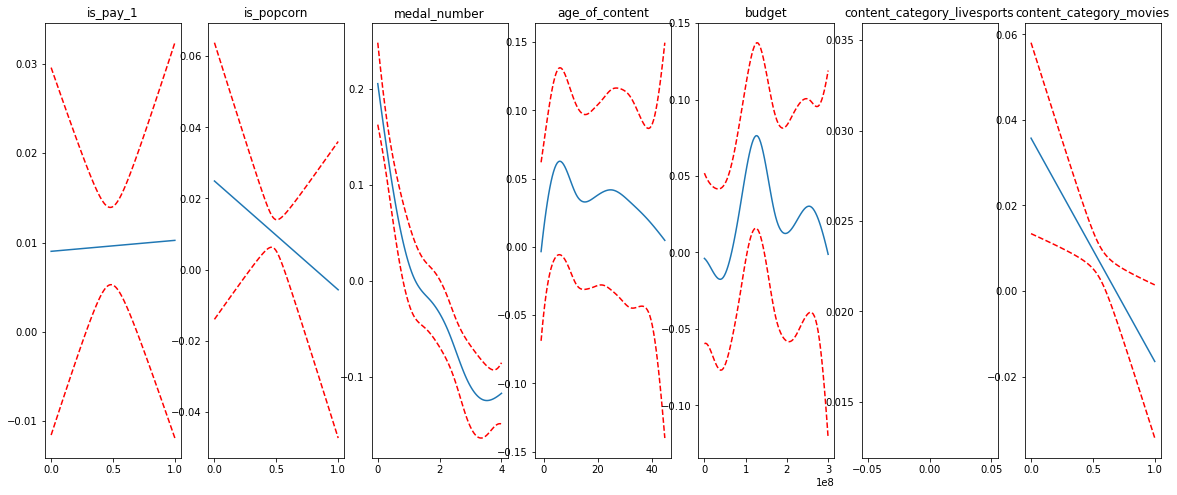

In [368]:
plt.rcParams['figure.figsize'] = (20, 8)
fig, axs = plt.subplots(1, 7)
titles = FEATURE_COLS
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [364]:
validation_set = validation_set[META_COLS+FEATURE_COLS+TARGET_COL+['pred']]

In [365]:
validation_set['pct_error'] = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]

In [366]:
validation_set[validation_set['title_name']=='House of the Dragon']

,title_name,title_id,season_number,offering_start_date,asset_run_time_hours,is_pay_1,is_popcorn,medal_number,age_of_content,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,genre_Action/Adventure,ahvr,pred,pct_error
39,House of the Dragon,GYsYeoAxKH8LCwgEAAAOR,1,2022-08-22,10.2592,0,0,0.0000,-0.1698,0.0000,0,0,1,0,0,0.5004,0.3849,0.2308


In [357]:
validation_set[validation_set['pct_error']>2]

,title_name,title_id,season_number,offering_start_date,asset_run_time_hours,is_pay_1,is_popcorn,medal_number,age_of_content,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,genre_Action/Adventure,ahvr,pred,pct_error
0,Cast Away,GV7tyCwdtM8MbwgEAAAAi,0,2020-05-27,2.3492,0,0,4.0000,8.7284,"90,000,000.0000",0,1,0,0,1,0.0382,0.1543,3.0401
25,The Predator,GXILenABPPL2DVwEAAACA,0,2020-05-27,1.7850,1,0,4.0000,1.7002,"88,000,000.0000",0,1,0,0,1,0.0373,0.1398,2.7425
32,Rio,GXRtqyQJVuJVLqQEAAAC7,0,2020-05-27,1.5983,0,0,4.0000,9.1172,"90,000,000.0000",0,1,0,0,0,0.0339,0.1040,2.0662
33,Quantum of Solace,GXSybfg37fJVLqQEAAATy,0,2020-05-27,1.7331,0,0,4.0000,11.5321,"200,000,000.0000",0,1,0,0,1,0.0333,0.1041,2.1252
40,Green Lantern,GXXAljgW4WcPCwgEAAAHP,0,2020-05-27,1.9156,0,0,4.0000,8.9447,"200,000,000.0000",0,1,0,0,1,0.0314,0.1269,3.0481
84,Batman: The Dark Knight Returns Part 1,GXdu2UQBElaXCPQEAADfM,0,2020-05-27,1.2450,0,0,4.0000,8.4026,"3,500,000.0000",0,1,0,0,1,0.0349,0.1170,2.3492
92,Cowboys & Aliens,GXfuVnwyAm0ytlAEAABQJ,0,2020-05-27,1.9681,0,0,4.0000,8.8298,"163,000,000.0000",0,1,0,0,1,0.0313,0.1410,3.5023
109,Batman v Superman: Dawn of Justice,GXnEEqw6PJp4_wwEAAEv1,0,2020-05-27,2.5267,0,0,4.0000,4.1726,"250,000,000.0000",0,1,0,0,1,0.0401,0.1478,2.6903
122,The Boondocks,GXrMEtQ8sromBSgEAAAK1,4,2020-05-27,3.7553,0,0,4.0000,6.4012,0.0000,0,0,1,0,0,0.0318,0.1076,2.3823
33,THE NEVERS,GYBllVQbyTkOLlAEAAAAC,1,2021-04-12,5.8469,0,0,1.0000,-0.0931,0.0000,0,0,1,0,0,0.0605,0.1846,2.0494


## 1.3 Log AVHR

In [17]:
# !pip install pygam

In [11]:
validation_data.head()

,Unnamed: 0,title_name,title_id,season_number,days_on_hbo_max,cumulative_hours_viewed,average_hours_viewed,offering_start_date,asset_run_time_hours,content_category,program_type,air_date,medal,episode_number_in_season,pillar_genre,is_pay_1,is_popcorn,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Adult Animation,genre_Classics,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Kids/Family,genre_Music,genre_Other,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,genre_Unscripted,medal_number,is_new_content,age_of_content,content_category_livesports.1,content_category_movies.1,content_category_series.1,content_category_special.1,program_type_acquired.1,program_type_original.1,genre_Action/Adventure .1,genre_Adult Animation.1,genre_Classics.1,genre_Comedy.1,genre_Documentary.1,genre_Drama.1,genre_Horror .1,genre_Kids/Family.1,genre_Music.1,genre_Other.1,genre_Romance.1,genre_Sci-Fi.1,genre_Suspense/Thriller.1,genre_Unscripted.1,content_category_livesports.2,content_category_movies.2,content_category_series.2,content_category_special.2,program_type_acquired.2,program_type_original.2,genre_Action/Adventure .2,genre_Adult Animation.2,genre_Classics.2,genre_Comedy.2,genre_Documentary.2,genre_Drama.2,genre_Horror .2,genre_Kids/Family.2,genre_Music.2,genre_Other.2,genre_Romance.2,genre_Sci-Fi.2,genre_Suspense/Thriller.2,genre_Unscripted.2,hvr,ahvr,content_cost
0,0,VICE Special Report: Killing Cancer,GV-54_wnG7qbCwwEAAAAY,0,60,64.6272,0.0000,2020-05-27,0.6400,movies,acquired,2015-01-01,None,nan,Documentary,0,0,nan,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,nan,0,5.4019,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,100.9800,0.0001,nan
1,1,VICE Special Report: Countdown to Zero,GV-55HghKlqbCwwEAAAAb,0,60,32.5694,0.0000,2020-05-27,0.8097,movies,acquired,2015-01-01,None,nan,Documentary,0,0,nan,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,nan,0,5.4019,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,40.2230,0.0000,nan
2,2,VICE Special Report: Fixing the System,GV-55Hwvj4IaDwwEAAAAY,0,60,139.3297,0.0001,2020-05-27,1.1081,movies,acquired,2015-01-01,None,nan,Documentary,0,0,nan,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,nan,0,5.4019,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,125.7426,0.0001,nan
3,3,VICE Special Report: Fighting ISIS,GV-55JASHjruwgwEAAAAU,0,60,163.4364,0.0001,2020-05-27,0.7864,movies,original,2016-01-31,None,nan,Documentary,0,0,nan,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,nan,0,4.3204,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,207.8317,0.0002,nan
4,4,Heartbreakers,GV-BGJA11hsLDwwEAAAAZ,0,60,"11,945.0525",0.0039,2020-09-01,2.0578,movies,acquired,2001-03-23,None,nan,Comedy,0,0,"35,000,000.0000",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,nan,0,19.4446,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"5,804.8333",0.0019,"259,000.0000"


In [12]:
validation_data.content_category.unique()

array(['movies', 'series', 'special', nan, 'livesports'], dtype=object)

#### 1.3.1 Significant title classifier

In [93]:
training_data = validation_data.copy()

In [94]:
training_data['is_significant_title'] = 1
training_data.loc[training_data['ahvr'] < 0.015, 'is_significant_title'] = 0

In [95]:
training_data[FEATURE_COLS].isnull().sum()/len(training_data)
## Checking if there are any nulls in the feature columns

is_pay_1                  0.0000
is_popcorn                0.0000
medal_number              0.9225
age_of_content            0.0020
content_category_movies   0.0000
content_category_series   0.0000
program_type_acquired     0.0000
program_type_original     0.0000
genre_Action/Adventure    0.0000
genre_Classics            0.0000
genre_Horror              0.0000
dtype: float64

In [96]:
training_data['medal_number'] = training_data['medal_number'].fillna(3)
training_data['content_cost'] = training_data['content_cost'].fillna(0)
training_data['age_of_content'] = training_data['age_of_content'].fillna(100)

In [97]:
FEATURE_COLS = ['is_pay_1', 
                'is_popcorn', 
#                 'is_new_content', 
                'medal_number', 
                'age_of_content', 
#                 'content_cost', #XX
#                 'budget', 
#                 'content_category_livesports', 
                'content_category_movies', 
                'content_category_series', 
#                 'content_category_special', 
                'program_type_acquired', 
                'program_type_original', 
                'genre_Action/Adventure ', 
#                 'Dominant_Topic_7.0'    XX
                'genre_Classics',  
                'genre_Horror '
               ]

In [98]:
TARGET_COL = ['is_significant_title']

In [99]:
from sklearn.linear_model import LogisticRegression

In [100]:
num_fold = 10
group_kfold = GroupKFold(n_splits=num_fold)

In [101]:
validation_set = pd.DataFrame()

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model|
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        clf = LogisticRegression(random_state=0).fit(X_train, y_train)
        pred = clf.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)
        print (clf.score(X_train, y_train))

    except Exception as e:
        print (e)
        raise 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.893039303930393


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8960396039603961


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d arra

0.8987398739873987


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8978397839783978


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8963396339633963


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8966396639663966


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8973897389738974


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.896655167241638


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8974051297435128
0.8971051447427628


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [72]:
validation_set.head()

,Unnamed: 0,title_name,title_id,season_number,days_on_hbo_max,cumulative_hours_viewed,average_hours_viewed,offering_start_date,asset_run_time_hours,content_category,program_type,air_date,medal,episode_number_in_season,pillar_genre,is_pay_1,is_popcorn,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Adult Animation,genre_Classics,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Kids/Family,genre_Music,genre_Other,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,genre_Unscripted,medal_number,is_new_content,age_of_content,content_category_livesports.1,content_category_movies.1,content_category_series.1,content_category_special.1,program_type_acquired.1,program_type_original.1,genre_Action/Adventure .1,genre_Adult Animation.1,genre_Classics.1,genre_Comedy.1,genre_Documentary.1,genre_Drama.1,genre_Horror .1,genre_Kids/Family.1,genre_Music.1,genre_Other.1,genre_Romance.1,genre_Sci-Fi.1,genre_Suspense/Thriller.1,genre_Unscripted.1,content_category_livesports.2,content_category_movies.2,content_category_series.2,content_category_special.2,program_type_acquired.2,program_type_original.2,genre_Action/Adventure .2,genre_Adult Animation.2,genre_Classics.2,genre_Comedy.2,genre_Documentary.2,genre_Drama.2,genre_Horror .2,genre_Kids/Family.2,genre_Music.2,genre_Other.2,genre_Romance.2,genre_Sci-Fi.2,genre_Suspense/Thriller.2,genre_Unscripted.2,hvr,ahvr,content_cost,is_significant_title,pred
0,3,VICE Special Report: Fighting ISIS,GV-55JASHjruwgwEAAAAU,0,60,163.4364,0.0001,2020-05-27,0.7864,movies,original,2016-01-31,None,nan,Documentary,0,0,nan,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3.0000,0,4.3204,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,207.8317,0.0002,0.0000,0,0
1,13,Race,GV-BPkgQsScLDwwEAAACE,0,60,"11,203.9844",0.0009,2022-11-01,2.2411,movies,acquired,2016-02-19,None,nan,Drama,0,0,"35,000,000.0000",0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.0000,0,6.6997,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,"4,999.2992",0.0004,"1,305,893.0000",0,0
2,29,Ghost in the Machine,GV1nlGAvbfbyvSwEAAAA4,0,60,"2,809.5461",0.0002,2021-07-01,1.5883,movies,acquired,1993-12-29,None,nan,Horror,0,0,"12,000,000.0000",0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3.0000,0,27.5050,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,"1,768.8647",0.0001,"349,333.0000",0,0
3,42,The Conspirator,GV40E6Qsrx7fDNQEAAAA-,0,60,"6,793.5100",0.0005,2021-11-01,1.9958,movies,acquired,2010-01-01,None,nan,Drama,0,0,"25,000,000.0000",0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.0000,0,11.8332,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,"3,403.8469",0.0003,"125,000.0000",0,0
4,66,Habla y vota,GV6zFJwLTMazCKQEAAAAc,0,60,40.4183,0.0000,2020-05-27,0.9183,movies,original,2016-09-16,None,nan,Other,0,0,nan,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.0000,0,3.6934,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,44.0127,0.0000,0.0000,0,0


#### 1.3.2 Modeling

In [102]:
training_data = validation_data[(validation_data['ahvr']>0.015)]
# training_data = validation_data[(validation_data['content_category'].isin(['movies', 'series', 'special']))]

In [103]:
len(training_data.title_id.unique())

753

In [104]:
from pygam import LinearGAM, s, PoissonGAM

In [105]:
FEATURE_COLS = ['is_pay_1', 
                'is_popcorn', 
#                 'is_new_content', 
                'medal_number', 
                'age_of_content', 
#                 'content_cost', #XX
#                 'budget', 
#                 'content_category_livesports', 
                'content_category_movies', 
                'content_category_series', 
#                 'content_category_special', 
                'program_type_acquired', 
                'program_type_original', 
                'genre_Action/Adventure ', 
#                 'Dominant_Topic_7.0'    XX
                'genre_Classics',  
                'genre_Horror '
               ]

In [106]:
training_data['log_ahvr'] = np.log2(training_data['ahvr'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [107]:
TARGET_COL = ['log_ahvr']

In [108]:
training_data[FEATURE_COLS].isnull().sum()/len(training_data)
## Checking if there are any nulls in the feature columns

is_pay_1                  0.0000
is_popcorn                0.0000
medal_number              0.7432
age_of_content            0.0000
content_category_movies   0.0000
content_category_series   0.0000
program_type_acquired     0.0000
program_type_original     0.0000
genre_Action/Adventure    0.0000
genre_Classics            0.0000
genre_Horror              0.0000
dtype: float64

In [109]:
training_data['medal_number'] = training_data['medal_number'].fillna(3)
training_data['content_cost'] = training_data['content_cost'].fillna(0)
training_data['age_of_content'] = training_data['age_of_content'].fillna(100)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [110]:
num_fold = 10
group_kfold = GroupKFold(n_splits=num_fold)

In [111]:
### DOWNSIDE --- DO NOT TAKE NULL ####
validation_set = pd.DataFrame()
# feature_importances = pd.DataFrame()
# gam = LinearGAM(s(0))

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model|
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        gam = LinearGAM(n_splines=10).fit(X_train, y_train)
        pred = gam.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

    except Exception as e:
        print (e)
        raise 

In [112]:
cal_error(validation_set) #0.3869481250303666

0.3845531184472702

In [113]:
validation_set = validation_set[META_COLS+FEATURE_COLS+['ahvr']+TARGET_COL+['pred']]

In [114]:
validation_set['pred_antilog'] = 2**(validation_set['pred'])

In [115]:
def cal_true_error(validation_set):
    error_col = (validation_set['pred_antilog']-validation_set['ahvr']).abs()/validation_set['ahvr']
    return error_col.mean()

In [116]:
cal_true_error(validation_set)

0.6884100863200664

In [33]:
validation_set['pct_error'] = (validation_set['pred_antilog']-validation_set['ahvr']).abs()/validation_set['ahvr']

In [34]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=10).fit(X, y)

In [35]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     23.5212
Link Function:                     IdentityLink Log Likelihood:                                -21703.0077
Number of Samples:                         7397 AIC:                                            43455.0578
                                                AICc:                                           43455.2276
                                                GCV:                                                 7.025
                                                Scale:                                              6.9848
                                                Pseudo R-Squared:                                    0.258
Feature Function                  Lam

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  if __name__ == '__main__':


In [36]:
import matplotlib.pyplot as plt

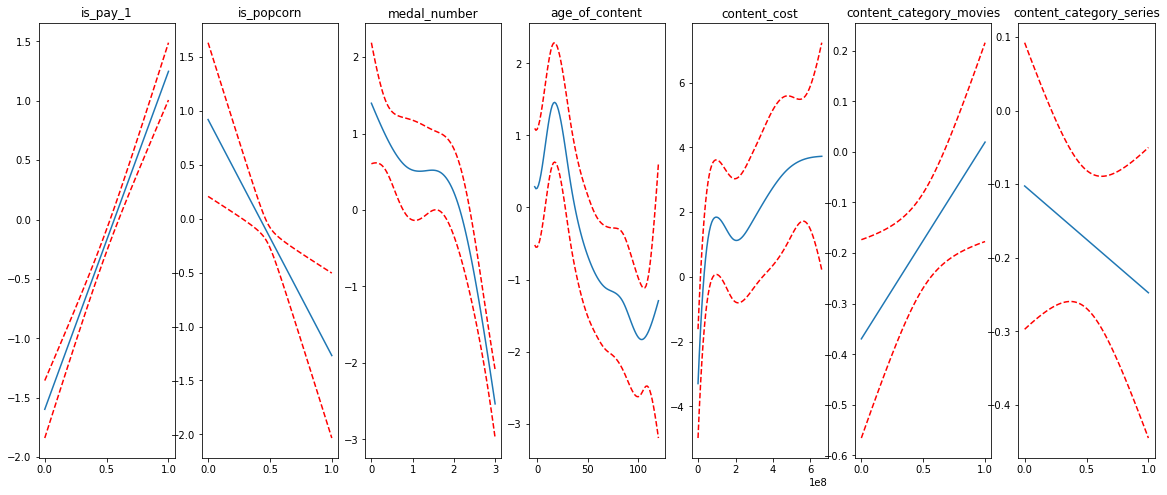

In [37]:
plt.rcParams['figure.figsize'] = (20, 8)
fig, axs = plt.subplots(1, 7)
titles = FEATURE_COLS
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [43]:
# validation_set.loc[validation_set['pred_antilog'] < 0.015, 'pred_antilog'] = 0 
# validation_set.loc[validation_set['ahvr'] < 0.015, 'ahvr'] = 0 
# validation_set['pct_error'] = (validation_set['pred_antilog']-validation_set['ahvr']).abs()/validation_set['ahvr']

In [44]:
# cal_true_error(validation_set[validation_set['ahvr']>0])

1.2672912920846071

In [47]:
validation_set[(validation_set['pct_error']>2) & (validation_set['ahvr']>0)]

,title_name,title_id,season_number,offering_start_date,air_date,asset_run_time_hours,content_category,program_type,medal,pillar_genre,is_pay_1,is_popcorn,medal_number,age_of_content,content_cost,content_category_movies,content_category_series,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Classics,genre_Horror,ahvr,log_ahvr,pred,pred_antilog,pct_error
522,Tenet,GYEq4eApHYpA4cwEAAAAC,0,2021-05-02,2020-01-01,2.4511,movies,acquired,Gold,Action/Adventure,1,0,1.0000,1.3334,"12,600,326.0000",1,0,1,0,1,0,0,0.1005,-3.3144,-0.9748,0.5088,4.0617
614,Dune,GYUjdLgBiJp5otAEAAAAJ,0,2021-10-21,2021-10-21,2.5547,movies,acquired,Platinum,Action/Adventure,1,1,0.0000,0.0000,"46,244,531.0000",1,0,1,0,1,0,0,0.0972,-3.3628,0.4276,1.3450,12.8365
686,The Staircase,GYk93MwWuH4BJoAEAAABu,1,2022-05-05,2022-06-09,8.5122,series,original,Gold,Drama,0,0,1.0000,-0.0958,"129,300,000.0000",0,1,0,1,0,0,0,0.0285,-5.1317,-2.5938,0.1657,4.8077
500,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,0,2021-03-31,2021-03-31,1.8600,movies,acquired,Platinum,Action/Adventure,1,1,0.0000,0.0000,"46,934,901.0000",1,0,1,0,1,0,0,0.3679,-1.4425,0.2344,1.1764,2.1974
572,No Sudden Move,GYMzEGg049ruJvQEAAAAW,0,2021-07-01,2021-07-01,1.8792,movies,acquired,Gold,Drama,0,0,1.0000,0.0000,"53,774,331.0000",1,0,1,0,0,0,0,0.0374,-4.7414,-2.6614,0.1581,3.2283
585,The Conjuring: The Devil Made Me Do It,GYOYX9gphVFOLNgEAAAQR,0,2021-10-21,2021-06-04,1.8250,movies,acquired,Silver,Horror,1,0,2.0000,0.3806,"40,399,489.0000",1,0,1,0,0,0,1,0.0156,-6.0060,0.4012,1.3206,83.8688
664,F9: The Fast Saga,GYfim_QUVfBqboQEAAAC-,0,2022-03-04,2021-06-25,2.3817,movies,acquired,Gold,Action/Adventure,1,0,1.0000,0.6900,"17,550,000.0000",1,0,1,0,1,0,0,0.0445,-4.4895,-0.3557,0.7815,16.5549
716,Moonfall,GYt_9-AbG4b3CaQEAAAy3,0,2022-09-09,2022-02-04,2.1444,movies,acquired,Gold,Action/Adventure,1,0,1.0000,0.5941,"5,814,413.0000",1,0,1,0,1,0,0,0.0497,-4.3307,-1.6582,0.3168,5.3753
596,Malignant,GYSaKIQwrHruinAEAAABN,0,2021-09-10,2021-09-10,1.8211,movies,acquired,Platinum,Horror,1,1,0.0000,0.0000,"14,744,810.0000",1,0,1,0,0,0,1,0.0579,-4.1093,-2.2441,0.2111,2.6431
636,And Just Like That...,GYYxBtQFFnmbDBwEAAAAE,1,2021-12-09,2022-02-03,6.4914,series,original,Platinum,Comedy,0,0,0.0000,-0.1533,"114,700,000.0000",0,1,0,1,0,0,0,0.0835,-3.5824,-1.7604,0.2952,2.5357


In [87]:
validation_set.to_csv('validation_set.csv')

## 1.4 Scale AVHR and Feature

In [18]:
# !pip install pygam

In [26]:
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer()

In [92]:
training_data = validation_data[(validation_data['ahvr']>0.03)]

In [93]:
len(training_data.title_id.unique())

398

In [94]:
from pygam import LinearGAM, s, PoissonGAM

In [95]:
training_data['quantile_ahvr'] = scaler.fit_transform(training_data['ahvr'].values.reshape(-1, 1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [96]:
TARGET_COL = ['quantile_ahvr']

In [97]:
FEATURE_COLS = ['is_pay_1', 
                'is_popcorn', 
#                 'is_new_content', 
                'medal_number', 
                'age_of_content', 
                'content_cost', #XX
#                 'budget', 
#                 'content_category_livesports', 
                'content_category_movies', 
                'content_category_series', 
#                 'content_category_special', 
                'program_type_acquired', 
                'program_type_original', 
                'genre_Action/Adventure ', 
#                 'Dominant_Topic_7.0'    XX
                'genre_Classics',  
                'genre_Horror '
               ]

In [98]:
training_data[FEATURE_COLS].isnull().sum()/len(training_data)
## Checking if there are any nulls in the feature columns

is_pay_1                  0.0000
is_popcorn                0.0000
medal_number              0.0000
age_of_content            0.0000
content_cost              0.0000
content_category_movies   0.0000
content_category_series   0.0000
program_type_acquired     0.0000
program_type_original     0.0000
genre_Action/Adventure    0.0000
genre_Classics            0.0000
genre_Horror              0.0000
dtype: float64

In [99]:
# training_data['content_cost_scaled'] = scaler.fit_transform(training_data['content_cost'].values.reshape(-1, 1))

In [100]:
training_data['medal_number'] = training_data['medal_number'].fillna(4)
training_data['content_cost'] = training_data['content_cost'].fillna(0)
training_data['age_of_content'] = training_data['age_of_content'].fillna(0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [101]:
num_fold = 10
group_kfold = GroupKFold(n_splits=num_fold)

In [102]:
### DOWNSIDE --- DO NOT TAKE NULL ####
validation_set = pd.DataFrame()
# feature_importances = pd.DataFrame()
# gam = LinearGAM(s(0))

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model|
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        gam = LinearGAM(n_splines=10).fit(X_train, y_train)
        pred = gam.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

    except Exception as e:
        print (e)
        raise 

In [103]:
cal_error(validation_set) #

inf

In [104]:
validation_set = validation_set[META_COLS+FEATURE_COLS+['ahvr']+TARGET_COL+['pred']]

In [105]:
validation_set['pred_transform'] = scaler.transform(validation_set['pred'].values.reshape(-1, 1))

In [106]:
def cal_true_error(validation_set):
    error_col = (validation_set['pred_transform']-validation_set['ahvr']).abs()/validation_set['ahvr']
    return error_col.mean()

In [107]:
cal_true_error(validation_set)

0.9211277147306077

In [108]:
validation_set['pct_error'] = (validation_set['pred_transform']-validation_set['ahvr']).abs()/validation_set['ahvr']

In [109]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=10).fit(X, y)

In [110]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      20.236
Link Function:                     IdentityLink Log Likelihood:                                -35093.6486
Number of Samples:                          487 AIC:                                            70229.7692
                                                AICc:                                           70231.8012
                                                GCV:                                                0.0068
                                                Scale:                                              0.0063
                                                Pseudo R-Squared:                                   0.2623
Feature Function                  Lam

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  if __name__ == '__main__':


In [111]:
import matplotlib.pyplot as plt

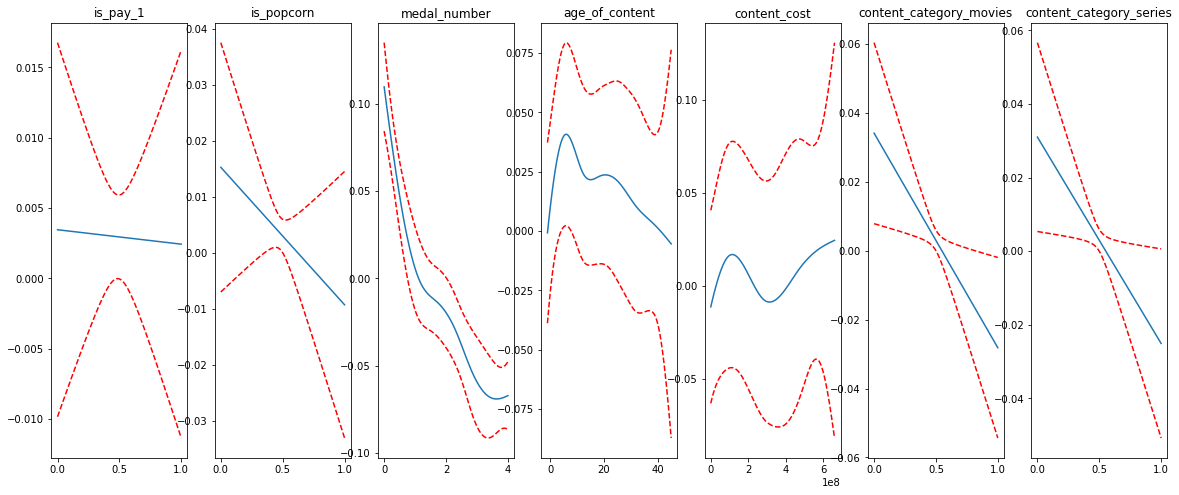

In [112]:
plt.rcParams['figure.figsize'] = (20, 8)
fig, axs = plt.subplots(1, 7)
titles = FEATURE_COLS
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [113]:
validation_set.head()

,title_name,title_id,season_number,offering_start_date,air_date,asset_run_time_hours,content_category,program_type,medal,pillar_genre,is_pay_1,is_popcorn,medal_number,age_of_content,content_cost,content_category_movies,content_category_series,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Classics,genre_Horror,ahvr,quantile_ahvr,pred,pred_transform,pct_error
0,It,GWt7vKAJzFri8vQEAAAKm,0,2020-10-27,2017-01-01,2.1964,movies,acquired,None,Horror,0,0,4.0000,3.8194,"9,029,193.0000",1,0,1,0,0,0,1,0.0585,0.0161,0.0170,-0.0073,1.1250
1,Snow White and the Huntsman,GX42eRA3gLmNViQEAAAYP,0,2020-12-01,2012-06-01,2.0739,movies,acquired,None,Action/Adventure,0,0,4.0000,8.5012,"3,646,400.0000",1,0,1,0,1,0,0,0.0484,0.0104,0.0560,0.0146,0.6977
2,The Bee Gees: How Can You Mend A Broken Heart,GX5lfBgOJ7RKRwgEAAAMG,0,2020-12-13,2020-12-12,1.8503,movies,original,Silver,Documentary,0,0,2.0000,0.0027,"4,500,000.0000",1,0,0,1,0,0,0,0.1034,0.0414,0.0447,0.0083,0.9201
3,Deathstroke: Knights & Dragons,GX9jvbw7CW3idqQEAAABV,0,2021-01-01,2020-08-18,1.4161,movies,acquired,None,Action/Adventure,0,0,4.0000,0.3724,"1,080,000.0000",1,0,1,0,1,0,0,0.0330,0.0017,0.0283,-0.0010,1.0299
4,Chernobyl,GXJvkMAU0JIG6gAEAAAIo,1,2020-05-27,2019-06-03,5.2950,series,original,None,Drama,0,0,4.0000,0.9829,"16,200,000.0000",0,1,0,1,0,0,0,0.0394,0.0053,0.0213,-0.0049,1.1244


In [134]:
validation_data[(validation_data['ahvr']<0.015)
              &(validation_data['is_pay_1'] == 1)]

,Unnamed: 0,title_name,title_id,season_number,days_on_hbo_max,cumulative_hours_viewed,average_hours_viewed,offering_start_date,asset_run_time_hours,content_category,program_type,air_date,medal,episode_number_in_season,pillar_genre,is_pay_1,is_popcorn,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Adult Animation,genre_Classics,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Kids/Family,genre_Music,genre_Other,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,genre_Unscripted,medal_number,is_new_content,age_of_content,hvr,ahvr,content_cost,Dominant_Topic,Dominant_Topic_0.0,Dominant_Topic_1.0,Dominant_Topic_2.0,Dominant_Topic_3.0,Dominant_Topic_4.0,Dominant_Topic_5.0,Dominant_Topic_6.0,Dominant_Topic_7.0,log_ahvr
1778,1778,Smallfoot,GXJPDsQO4lYqlUQEAAAA1,0,60,"28,313.2031",0.0215,2020-05-27,1.5606,movies,acquired,2018-09-28,None,nan,Kids/Family,1,0,"80,000,000.0000",0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4.0000,0,1.6619,"18,143.0344",0.0138,"544,915.0000",2.0000,0,0,1,0,0,0,0,0,-0.0236
1837,1837,Sgt. Stubby: An American Hero,GXORWDQ0tgYDCwgEAAAB0,0,60,"2,445.9106",0.0019,2020-05-27,1.4064,movies,acquired,2019-07-01,None,nan,Kids/Family,1,0,"25,000,000.0000",0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4.0000,1,0.9062,"1,739.1435",0.0013,"187,500.0000",0.0000,1,0,0,0,0,0,0,0,-0.0420
1861,1861,Boy Erased,GXRtp4gizy729bAEAAACY,0,60,"9,836.9119",0.0075,2020-05-27,1.9122,movies,acquired,2018-11-02,None,nan,Drama,1,0,"11,000,000.0000",0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.0000,0,1.5661,"5,144.2311",0.0039,"1,016,626.0000",4.0000,0,0,0,0,1,0,0,0,-0.0381
1866,1866,Arizona,GXRtqqwIqPb29bAEAAACo,0,60,"19,555.2139",0.0148,2020-05-27,1.3936,movies,acquired,2018-12-28,None,nan,Comedy,1,0,nan,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4.0000,0,1.4128,"14,032.0462",0.0106,0.0000,nan,0,0,0,0,0,0,0,0,-0.0282
1904,1904,Dragged Across Concrete,GXSybgAKqor29bAEAAAT3,0,60,"12,230.7100",0.0093,2020-05-27,2.6044,movies,acquired,2018-12-31,None,nan,Suspense/Thriller,1,0,"15,000,000.0000",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.0000,0,1.4045,"4,696.0925",0.0036,"183,335.0000",5.0000,0,0,0,0,0,1,0,0,-0.0387
1906,1906,Johnny English Strikes Again,GXSybiA7hkk6olAEAAALc,0,60,"9,336.1769",0.0071,2020-05-27,1.4753,movies,acquired,2018-10-26,None,nan,Comedy,1,0,"25,000,000.0000",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4.0000,0,1.5852,"6,328.4230",0.0048,"501,015.0000",5.0000,0,0,0,0,0,1,0,0,-0.0368
1915,1915,The Little Stranger,GXSycCAC0ir29bAEAAAkj,0,60,"8,472.6167",0.0064,2020-05-27,1.8606,movies,acquired,2018-08-31,None,nan,Drama,1,0,nan,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.0000,0,1.7386,"4,553.8115",0.0035,0.0000,nan,0,0,0,0,0,0,0,0,-0.0388
1929,1929,Bigger,GXSycHgK48b29bAEAAAp1,0,60,"1,915.8003",0.0015,2020-05-27,1.7881,movies,acquired,2018-10-12,None,nan,Drama,1,0,nan,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.0000,0,1.6236,"1,071.4437",0.0008,"125,000.0000",nan,0,0,0,0,0,0,0,0,-0.0427
1938,1938,Galveston,GXSycMAbuzpVLqQEAAAsf,0,60,"12,984.7086",0.0099,2020-05-27,1.5247,movies,acquired,2018-01-01,None,nan,Drama,1,0,nan,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.0000,0,2.4011,"8,516.1155",0.0065,"120,690.0000",5.0000,0,0,0,0,0,1,0,0,-0.0344
1947,1947,Hunter Killer,GXSycOgrvLr29bAEAAAxY,0,60,"36,304.9706",0.0276,2020-05-27,1.9706,movies,acquired,2018-10-26,None,nan,Action/Adventure,1,0,"40,000,000.0000",0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0000,0,1.5852,"18,423.7286",0.0140,"2,390,133.0000",nan,0,0,0,0,0,0,0,0,-0.0233


# Write to S3/SF

In [73]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [74]:
import boto3
import io

def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
output_bucket = 'hbo-outbound-datascience-content-dev'
s3 = boto3.resource('s3')
bucket = s3.Bucket(output_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    to_s3(filename, output_bucket, content)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [78]:
validation_set.columns

Index(['title_name', 'title_id', 'season_number', 'offering_start_date',
       'air_date', 'asset_run_time_hours', 'content_category', 'program_type',
       'medal', 'pillar_genre', 'is_pay_1', 'is_popcorn', 'medal_number',
       'age_of_content', 'content_cost', 'content_category_movies',
       'content_category_series', 'program_type_acquired',
       'program_type_original', 'genre_Action/Adventure ', 'genre_Classics',
       'genre_Horror ', 'ahvr', 'log_ahvr', 'pred', 'pred_antilog',
       'pct_error'],
      dtype='object')

In [79]:
FINAL_OUTPUT_COL = ['title_name', 'title_id', 'season_number', 'offering_start_date',
       'air_date', 'asset_run_time_hours', 'content_category', 'program_type',
       'medal', 'pillar_genre', 'is_pay_1', 'is_popcorn', 'medal_number',
       'age_of_content', 'content_cost', 'average_hours_viewed', 'log_average_hours_viewed', 
        'pred_logged', 'prediction','pct_error']

In [80]:
validation_set.rename(columns = {'ahvr':'average_hours_viewed', 'log_ahvr':'log_average_hours_viewed', 
                                 'pred':'pred_logged', 'pred_antilog':'prediction'}, inplace = True)

In [81]:
write_to_sf(validation_set[FINAL_OUTPUT_COL], 'cross_validation_results.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [82]:
validation_set[FINAL_OUTPUT_COL].head()

,title_name,title_id,season_number,offering_start_date,air_date,asset_run_time_hours,content_category,program_type,medal,pillar_genre,is_pay_1,is_popcorn,medal_number,age_of_content,content_cost,average_hours_viewed,log_average_hours_viewed,pred_logged,prediction,pct_error
0,It,GWt7vKAJzFri8vQEAAAKm,0,2020-10-27,2017-01-01,2.1964,movies,acquired,None,Horror,0,0,4.0000,3.8194,"9,029,193.0000",0.0585,-4.0943,-4.1212,0.0575,0.0185
1,Snow White and the Huntsman,GX42eRA3gLmNViQEAAAYP,0,2020-12-01,2012-06-01,2.0739,movies,acquired,None,Action/Adventure,0,0,4.0000,8.5012,"3,646,400.0000",0.0484,-4.3680,-3.5002,0.0884,0.8249
2,The Bee Gees: How Can You Mend A Broken Heart,GX5lfBgOJ7RKRwgEAAAMG,0,2020-12-13,2020-12-12,1.8503,movies,original,Silver,Documentary,0,0,2.0000,0.0027,"4,500,000.0000",0.1034,-3.2737,-3.5817,0.0835,0.1922
3,Deathstroke: Knights & Dragons,GX9jvbw7CW3idqQEAAABV,0,2021-01-01,2020-08-18,1.4161,movies,acquired,None,Action/Adventure,0,0,4.0000,0.3724,"1,080,000.0000",0.0330,-4.9221,-3.8342,0.0701,1.1256
4,Chernobyl,GXJvkMAU0JIG6gAEAAAIo,1,2020-05-27,2019-06-03,5.2950,series,original,None,Drama,0,0,4.0000,0.9829,"16,200,000.0000",0.0394,-4.6653,-3.9352,0.0654,0.6588


In [84]:
run_query('''
create or replace table max_dev.workspace.user_title_hours_watched_crossvalidation 
(
title_name	VARCHAR,
title_id	VARCHAR,
season_number	int,
offering_start_date	VARCHAR,
air_date	VARCHAR,
asset_run_time_hours	float,
content_category	VARCHAR,
program_type	VARCHAR,
medal	VARCHAR,
pillar_genre	VARCHAR,
is_pay_1	int,
is_popcorn	int,
medal_number	int,
age_of_content	float,
content_cost	bigint,
average_hours_viewed	float,
log_average_hours_viewed	float,
pred_logged	float,
prediction	float,
pct_error	float
);

''')

,status
0,Table USER_TITLE_HOURS_WATCHED_CROSSVALIDATION...


In [86]:
run_query('''
copy into max_dev.workspace.user_title_hours_watched_crossvalidation
    from(
        select
              $1, $2, $3, $4, $5, $6, $7, $8, $9, $10, $11, $12,$13, $14, $15, $16, $17, $18, $19, $20
        from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/title_hours_viewed_retention/cross_validation_results.csv
        )
    file_format = (type = csv null_if=('') skip_header = 1  FIELD_OPTIONALLY_ENCLOSED_BY='"')
    on_error = 'CONTINUE';

''')

,file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
0,s3://hbo-outbound-datascience-content-dev/titl...,LOADED,487,487,487,0,None,None,None,None


# 